In [ ]:
"""
https://watlab-blog.com/2022/10/08/2d-diffusion/
https://watlab-blog.com/2022/10/02/2d-advection/
https://python.keicode.com/lang/regular-expression-finditer.php
"""

'\nhttps://watlab-blog.com/2022/10/08/2d-diffusion/\nhttps://watlab-blog.com/2022/10/02/2d-advection/\nhttps://python.keicode.com/lang/regular-expression-finditer.php\n'

In [ ]:
"""
更新箇所

gifで保存可能


今後
場をellipseにする
matrixをvolnoi分割


再考
単にwus0を前の状態として入れてあるが、よいか？

"""

'\n目的\n\n場をellipseにする\nmatrixをvolnoi分割\ngifで保存する\n\n\n\n再考\n単にwus0を前の状態として入れてあるが、よいか？\n\n'

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import os
import glob
import matplotlib.pyplot as plt
import re
import pandas as pd
from PIL import Image, ImageDraw
import io
import IPython.display as display
from collections import defaultdict

from google.colab import files

In [ ]:
# csvからparam取得

from google.colab import drive
drive.mount('/content/drive')
Sim_data= pd.read_csv('drive/My Drive/Colab Notebooks/Diffusion-ish/Mesh-type/Sim_Param.csv')


# Parameter_original
abc_idx, abc_par = Sim_data[1:1], Sim_data[0:1]

param_name = []
for n in abc_idx:
    param_name.append(n[0:4])

# pd 1row
param_ori = list(Sim_data.iloc[0])

for a, b in zip(param_name, param_ori):
    a = b

ID, K_CW, n_CW, k_Cr, K_CL, n_CL, K_CH, n_CH, k_Cp, b_Cr, b_Wr, k_WL, k_WC, k_Wr, K_WW, n_WW, K_WL, n_WL, K_WC, n_WC, k_Wp, b_Ww, b_Wr, ki_W, a_Cc, K_HW, n_HW, b_pp, k_pp, b_Hh, k_Hh, k_Ll, b_Ll, D_Ww, D_Cc, D_Ll = [a for a in param_ori]

#print(param_name)
#print(param_ori)

Mounted at /content/drive


In [ ]:
# Initial
wr_sigma11, wr_sigma22, wr_sigma12, wr_sigma21 = 900, 300, 0, 0
wp_sigma11, wp_sigma22, wp_sigma12, wp_sigma21 = 900, 300, 0, 0
cr_sigma11, cr_sigma22, cr_sigma12, cr_sigma21 = 200, 150, 0, 0
cp_sigma11, cp_sigma22, cp_sigma12, cp_sigma21 = 100, 50, 0, 0
eL_sigma11, eL_sigma22, eL_sigma12, eL_sigma21 = 60, 30, 0, 0
eR_sigma11, eR_sigma22, eR_sigma12, eR_sigma21 = 60, 30, 0, 0
h_sigma11, h_sigma22, h_sigma12, h_sigma21 = 10, 10, 0, 0

#            wr    wp    cr    cp    eL    eR     h
sigma11 = [    9,    9,    5,    5,    6,     6,    1]
sigma22 = [    3,    3,  1.5,  1.5,    3,     3,    1]
sigma12 = [    0,    0,    0,    0,    0,     0,    0]
sigma21 = [    0,    0,    0,    0,    0,     0,    0]


mu_wusr_x, mu_wusr_y = 5, 8
mu_wusp_x, mu_wusp_y = 5, 8
mu_clvr_x, mu_clvr_y = 5, 2
mu_clvp_x, mu_clvp_y = 5, 2
mu_erfL_x, mu_erfL_y = 2, 5
mu_erfR_x, mu_erfR_y = 7, 5
mu_ham_x, mu_ham_y = 5, 7

element_str = ["wusr", "wusp", "clvr", "clvp", "erfL", "erfR", "ham"]

# Space
x_max, y_max = 10, 10  # range
dx, dy = 0.5, 0.5  # divide

# Amplifier
wr_AMP, wp_AMP, cr_AMP, cp_AMP, eL_AMP, eR_AMP, h_AMP = 600, 150, 300, 150, 300, 300, 10

a = 1   # diffusion rate

# Calculation condition
dt = 0.0005  # Time
step = 50
result_interval = 10


#plsv_wusr, plsv_wusp, plsv_clvr, plsv_clvp, plsv_erfL, plsv_erfR, plsv_ham = 0, 0, 0, 0, 0, 0, 0
plsv_wusr, plsv_wusp, plsv_clvr, plsv_clvp, plsv_erfL, plsv_erfR, plsv_ham = 1, 1, 1, 1, 1, 1, 1

# component
wusr_str, wusp_str, clvr_str, clvp_str, erfL_str, erfR_str, ham_str = 'wusr', 'wusp', 'clvr', 'clvp', 'epflL', 'epflR', 'ham'
c_wusr, c_wusp, c_clvr, c_clvp, c_erfL, c_erfR, c_ham = 'jet', 'seismic', 'twilight_shifted', 'CMRmap', 'cividis', 'plasma', 'terrain'
# , , , , 'gist_stern', 'gnuplot',,, 'brg''gnuplot2' 'CMRmap''cubehelix'

#引数list
pull_sol = [dt, dx, dy, a, step, result_interval]


# GIF用
# 辞書 keylist
keys_name = ["wusr", "wusp", "clvr", "clvp", "erfL", "erfR", "ham"]

img_stock = defaultdict(list)

# 指定されたキーを追加
for key in keys_name:
    img_stock[key]  # defaultdictにキーを生成


In [ ]:
def initial_field(x, y):
    zero_wusr, zero_wusp, zero_clvr, zero_clvp, zero_erfL, zero_erfR, zero_ham = [np.zeros((len(y), len(x))) for n in range(7)]

    # 2D Gaussian(sigma:分散共分散行列, mu:平均ベクトル)
    wr_sigma, wp_sigma, cr_sigma, cp_sigma, eL_sigma, eR_sigma, h_sigma = [np.array([[a, b], [c, d]]) for a, b, c, d in zip(sigma11, sigma12, sigma21, sigma22)]

    wr_det_sigma = np.linalg.det(wr_sigma)
    wr_inv_sigma = np.linalg.inv(wr_sigma)
    wp_det_sigma = np.linalg.det(wp_sigma)
    wp_inv_sigma = np.linalg.inv(wp_sigma)
    cr_det_sigma = np.linalg.det(cr_sigma)
    cr_inv_sigma = np.linalg.inv(cr_sigma)
    cp_det_sigma = np.linalg.det(cp_sigma)
    cp_inv_sigma = np.linalg.inv(cp_sigma)
    eL_det_sigma = np.linalg.det(eL_sigma)
    eL_inv_sigma = np.linalg.inv(eL_sigma)
    eR_det_sigma = np.linalg.det(eR_sigma)
    eR_inv_sigma = np.linalg.inv(eR_sigma)
    h_det_sigma = np.linalg.det(h_sigma)
    h_inv_sigma = np.linalg.inv(h_sigma)



    def get_arr(z, xtemp, ytemp, det_sigma, inv_sigma, AMPP):

        arr = np.array([xtemp, ytemp])
        def z_arr(z):
            z_arr = z.T
            for i in range(len(z)):
                for j in range(len(z.T)):
                    Xarr = np.array([x[i], y[j]])
                    z_arr[i, j] = (1 / np.sqrt(2 * np.pi * det_sigma)) * np.exp((-1 / 2) * (Xarr - arr).T @ inv_sigma @ (Xarr - arr)) * AMPP
            return z_arr
        zz_arr = z_arr(z)
        zzz_arr = zz_arr.T
        return zzz_arr

    zero_list = [zero_wusr, zero_wusp, zero_clvr, zero_clvp, zero_erfL, zero_erfR, zero_ham]
    mu_x_list = [mu_wusr_x, mu_wusp_x, mu_clvr_x, mu_clvp_x, mu_erfL_x, mu_erfR_x, mu_ham_x]
    mu_y_list = [mu_wusr_y, mu_wusp_y, mu_clvr_y, mu_clvp_y, mu_erfL_y, mu_erfR_y, mu_ham_y]
    det_list = [wr_det_sigma, wp_det_sigma, cr_det_sigma, cp_det_sigma, eL_det_sigma, eR_det_sigma, h_det_sigma]
    inv_list = [wr_inv_sigma, wp_inv_sigma, cr_inv_sigma, cp_inv_sigma, eL_inv_sigma, eR_inv_sigma, h_inv_sigma]
    AMP_list = [wr_AMP, wp_AMP, cr_AMP, cp_AMP, eL_AMP, eR_AMP, h_AMP]
    zzz_wusr, zzz_wusp, zzz_clvr, zzz_clvp, zzz_erfL, zzz_erfR, zzz_ham =  [get_arr(a, b, c, d, e, f) for a, b, c, d, e, f in zip(zero_list, mu_x_list, mu_y_list, det_list, inv_list, AMP_list) ]

    return zzz_wusr, zzz_wusp, zzz_clvr, zzz_clvp, zzz_erfL, zzz_erfR, zzz_ham


def boundary_condition(a):
    a[:, 0], a[:, -1], a[0, :], a[-1, :] = 0, 0, 0, 0  # left, right, up. bottom
    return a


In [ ]:
def sol_2d_diffusion(x, y, wusr, wusp, clvr, clvp, erfL, erfR, ham, pull, ID):
    ''' 2次元拡散方程式を計算する '''
    element_var = [wusr, wusp, clvr, clvp, erfL, erfR, ham]

    dt, dx, dy, a, step, result_interval = pull[0:]
    wusr, wusp, clvr, clvp, erfL, erfR, ham = wusr.T, wusp.T, clvr.T, clvp.T, erfL.T, erfR.T, ham.T

    for n in range(step):
        wusr0, wusp0, clvr0, clvp0, erfL0, erfR0, ham0 = wusr.copy(), wusp.copy(), clvr.copy(), clvp.copy(), erfL.copy(), erfR.copy(), ham.copy()
        wusr0, wusp0, clvr0, clvp0, erfL0, erfR0, ham0 = np.floor(wusr0), np.floor(wusp0), np.floor(clvr0), np.floor(clvp0), np.floor(erfL0), np.floor(erfR0), np.floor(ham0)

        #print(wusr0)

        for i in range(1, len(wusr) - 1):
            for j in range(1, len(wusr.T) - 1):

                # b_W -> b_Ww, k0_W -> ki_W, a_C -> a_Cc, b_p -> b_pp, k_p -> k_pp, b_H -> b_Hh, k_H -> k_Hh, k_L -> k_Ll, b_L -> b_Ll, D_W -> D_Ww, D_C -> D_Cc, D_L -> D_Ll

                wusr[i, j] = wusr0[i, j]  +  dt * ( k_Wr * ((k_WL/(1 + ((erfL0[i, j] + erfR0[i, j]) / K_WL)**n_WL)) + (k_WC/(1+((clvp0[i, j]) / K_WC )**n_WC))) * (ki_W + ((wusp0[i, j] / K_WW)**n_WW / (1+(wusp0[i, j] / K_WW)**n_WW)))  - b_Wr * wusr0[i, j])
                wusp[i, j] = wusp0[i, j]  +  dt * ( k_Wp * wusr0[i, j] - b_Ww * wusp0[i, j]   +   D_Ww * (( wusp0[i+1, j] - 2 * wusp0[i, j] + wusp0[i-1, j] ) / dx ** 2 )   +   D_Ww * ((wusp0[i, j+1] - 2 * wusp0[i, j] + wusp0[i, j-1] ) / dy ** 2 ))
                clvr[i, j] = clvr0[i, j]  +  dt * ( (k_Cr / (1+((erfL0[i, j] + erfR0[i, j])/K_CL)**n_CL)) * (a_Cc + ((wusp0[i, j]/K_CW)**n_CW / (1 + (wusp0[i, j]/K_CW)**n_CW))) * (1/(1+(ham0[i, j]/K_CH)**n_CH))  - b_Cr * clvr0[i, j])
                clvp[i, j] = clvp0[i, j]  +  dt * ( k_Cp * clvr0[i, j] - b_Cr * clvp0[i, j]  +  D_Cc * (( clvp0[i+1, j] - 2 * clvp0[i, j] + clvp0[i-1, j]) / dx ** 2)  +  D_Cc * (( clvp0[i, j+1] - 2 * clvp0[i, j] + clvp0[i, j-1]) / dy ** 2 ))
                erfL[i, j] = erfL0[i, j]  +  dt * ( k_Ll - b_Ll * erfL0[i, j]   +   D_Ll * (( erfL0[i+1, j] - 2 * erfL0[i, j] + erfL0[i-1, j]) / dx ** 2)  +  D_Ll * ((erfL0[i, j+1] - 2 * erfL0[i, j] + erfL0[i, j-1] / dy ** 2 )))
                erfR[i, j] = erfR0[i, j]  +  dt * ( k_Ll - b_Ll * erfR0[i, j]   +   D_Ll * (( erfR0[i+1, j] - 2 * erfR0[i, j] + erfR0[i-1, j]) / dx ** 2)  +  D_Ll * ((erfR0[i, j+1] - 2 * erfR0[i, j] + erfR0[i, j-1] / dy ** 2 )))
                ham[i, j]  = ham0[i, j]   +  dt * ( k_pp - b_pp * ham0[i, j])

                """
                wusr[i, j] = wusr0[i, j]  +  dt * ( k_Wr * ((k_WL/(1 + ((erfL0[i, j] + erfR0[i, j]) / K_WL)**n_WL)) + (k_WC/(1+((clvp0[i, j]) / K_WC )**n_WC))) * (ki_W + ((wusp0[i, j] / K_WW)**n_WW / (1+(wusp0[i, j] / K_WW)**n_WW)))  - b_Wr * wusr0[i, j])
                wusp[i, j] = wusp0[i, j]  +  dt * ( k_Wp * wusr0[i, j] - b_Ww * wusp0[i, j] + D_Ww * (wusp0[i+1, j] - 2 * wusp0[i, j] + wusp0[i-1, j])  +  D_Ww * (wusp0[i, j+1] - 2 * wusp0[i, j] + wusp0[i, j-1]))
                clvr[i, j] = clvr0[i, j]  +  dt * ( (k_Cr / (1+((erfL0[i, j] + erfR0[i, j])/K_CL)**n_CL)) * (a_Cc + ((wusp0[i, j]/K_CW)**n_CW / (1 + (wusp0[i, j]/K_CW)**n_CW))) * (1/(1+(ham0[i, j]/K_CH)**n_CH))  - b_Cr * clvr0[i, j])
                clvp[i, j] = clvp0[i, j]  +  dt * ( k_Cp * clvr0[i, j] - b_Cr * clvp0[i, j] + D_Cc * (clvp0[i+1, j] - 2 * clvp0[i, j] + clvp0[i-1, j]) + D_Cc * (clvp0[i, j+1] - 2 * clvp0[i, j] + clvp0[i, j-1]))
                erfL[i, j] = erfL0[i, j]  +  dt * ( k_Ll - b_Ll * erfL0[i, j]  +  D_Ll * (erfL0[i+1, j] - 2 * erfL0[i, j] + erfL0[i-1, j])  +  D_Ll * (erfL0[i, j+1] - 2 * erfL0[i, j] + erfL0[i, j-1]))
                erfR[i, j] = erfR0[i, j]  +  dt * ( k_Ll - b_Ll * erfR0[i, j]  +  D_Ll * (erfR0[i+1, j] - 2 * erfR0[i, j] + erfR0[i-1, j])  +  D_Ll * (erfR0[i, j+1] - 2 * erfR0[i, j] + erfR0[i, j-1]))
                """

                """
                wusr[i, j] = wusr0[i, j]  +  k_Wr * ((k_WL/(1 + ((erfL0[i, j] + erfR0[i, j]) / K_WL)**n_WL)) + (k_WC/(1+((clvp0[i, j]) / K_WC )**n_WC))) * (ki_W + ((wusp0[i, j] / K_WW)**n_WW / (1+(wusp0[i, j] / K_WW)**n_WW)))  - b_Wr * wusr0[i, j]
                wusp[i, j] = wusp0[i, j]  +  k_Wp * wusr0[i, j] - b_Ww * wusp0[i, j] + D_Ww * (wusp0[i+1, j] - 2 * wusp0[i, j] + wusp0[i-1, j])  +  D_Ww * (wusp0[i, j+1] - 2 * wusp0[i, j] + wusp0[i, j-1])
                clvr[i, j] = clvr0[i, j]  +  (k_Cr / (1+((erfL0[i, j] + erfR0[i, j])/K_CL)**n_CL)) * (a_Cc + ((wusp0[i, j]/K_CW)**n_CW / (1 + (wusp0[i, j]/K_CW)**n_CW))) * (1/(1+(ham0[i, j]/K_CH)**n_CH))  - b_Cr * clvr0[i, j]
                clvp[i, j] = clvp0[i, j]  +  k_Cp * clvr0[i, j] - b_Cr * clvp0[i, j] + D_Cc * (clvp0[i+1, j] - 2 * clvp0[i, j] + clvp0[i-1, j]) + D_Cc * (clvp0[i, j+1] - 2 * clvp0[i, j] + clvp0[i, j-1])
                erfL[i, j] = erfL0[i, j]  +  k_Ll - b_Ll * erfL0[i, j]  +  D_Ll * (erfL0[i+1, j] - 2 * erfL0[i, j] + erfL0[i-1, j])  +  D_Ll * (erfL0[i, j+1] - 2 * erfL0[i, j] + erfL0[i, j-1])
                erfR[i, j] = erfR0[i, j]  +  k_Ll - b_Ll * erfR0[i, j]  +  D_Ll * (erfR0[i+1, j] - 2 * erfR0[i, j] + erfR0[i-1, j])  +  D_Ll * (erfR0[i, j+1] - 2 * erfR0[i, j] + erfR0[i, j-1])
                """


        wusr, wusp, clvr, clvp, erfL, erfR, ham = wusr.T, wusp.T, clvr.T, clvp.T, erfL.T, erfR.T, ham.T
        wusr, wusp, clvr, clvp, erfL, erfR, ham = [boundary_condition(a) for a in element_var]
        wusr, wusp, clvr, clvp, erfL, erfR, ham = wusr.T, wusp.T, clvr.T, clvp.T, erfL.T, erfR.T, ham.T

        if n % result_interval == 0:
            print('Iteration=', n)
            wusr, wusp, clvr, clvp, erfL, erfR, ham = wusr.T, wusp.T, clvr.T, clvp.T, erfL.T, erfR.T, ham.T

            #print(wusr0)
            #print(wusp0)
            #print(clvr0)
            #print(clvp0)
            #print(erfL0)
            #print(erfR0)

            if plsv_wusr == 1:
                plot(x, y, wusr, n, "wusr", c_wusr, ID)
            if plsv_wusp == 1:
                plot(x, y, wusp, n, "wusp", c_wusp, ID)
            if plsv_clvr == 1:
                plot(x, y, clvr, n, "clvr", c_clvr, ID)
            if plsv_clvp == 1:
                plot(x, y, clvp, n, "clvp", c_clvp, ID)
            if plsv_erfL == 1:
                plot(x, y, erfL, n, "erfL", c_erfL, ID)
            if plsv_erfR == 1:
                plot(x, y, erfR, n, "erfR", c_erfR, ID)
            if plsv_ham == 1:
                plot(x, y, ham, n, "ham", c_ham, ID)

            wusr, wusp, clvr, clvp, erfL, erfR, ham = wusr.T, wusp.T, clvr.T, clvp.T, erfL.T, erfR.T, ham.T

    return


In [ ]:
def plot(x, y, z, n, name, color, ID):

    plt.rcParams['font.size'] = 14
    # scale inside
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'

    x_size = 8
    y_size = int(0.8 * x_size * (np.max(y) / np.max(x)))
    fig = plt.figure(figsize=(x_size, y_size))
    ax1 = fig.add_subplot(111)
    ax1.yaxis.set_ticks_position('both')
    ax1.xaxis.set_ticks_position('both')
    ax1.set_xlabel('x_label')
    ax1.set_ylabel('y_label')

    im = ax1.imshow(z,
                    vmin=0, vmax=100,
                    extent=[np.min(x), np.max(x), np.min(y), np.max(y)],
                    aspect='auto', cmap=f'{color}')

    ax1.text(0.1, 0.1, str(name)+', Step='+str(n), color="black")
    ax1.text(7, 0.1, str(name)+', Step='+str(n), color="white")
    cbar = fig.colorbar(im)
    cbar.set_label(f'{name}')

    # save index
    #plt.savefig('Fig_'f'{ID}''_'f'{name}''_'f'{n}''.png')
    #files.download('Fig_'f'{ID}''_'f'{name}''_'f'{n}''.png')



    # メモリ上に保存
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    img_stock[name].append(Image.open(buf))

    plt.show()
    plt.close(fig)




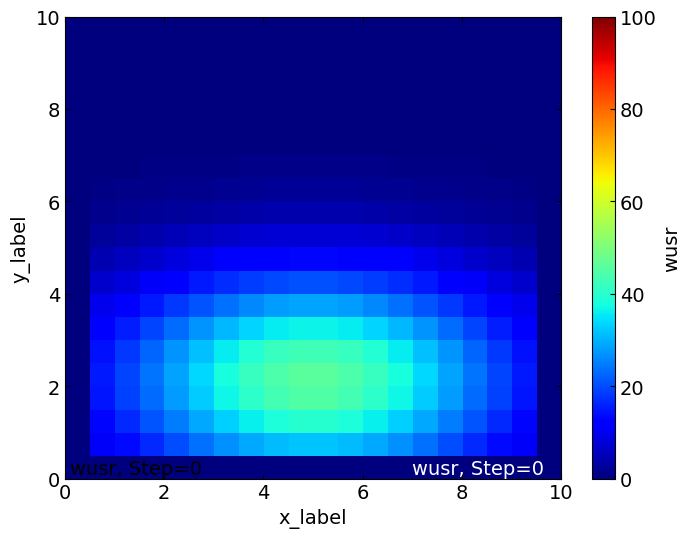

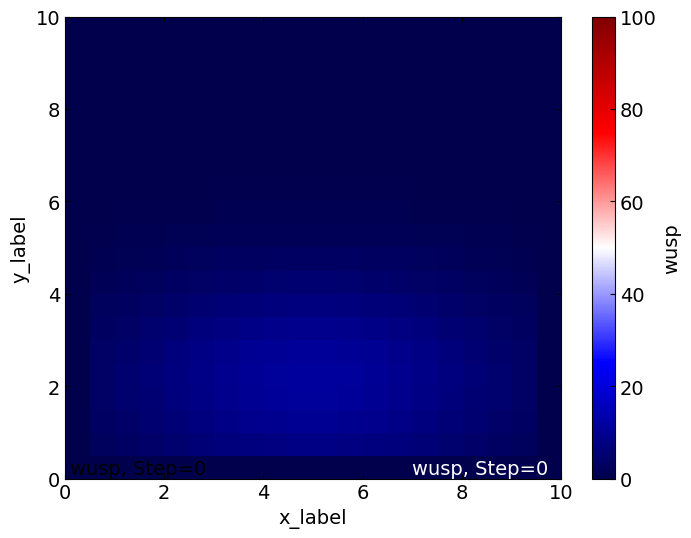

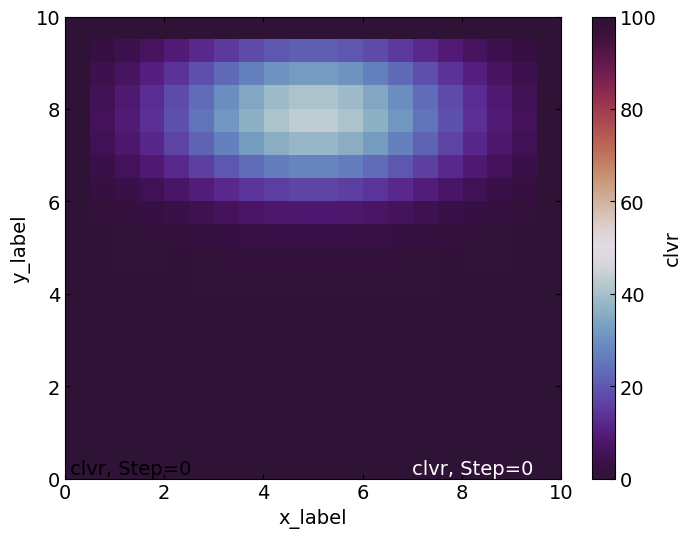

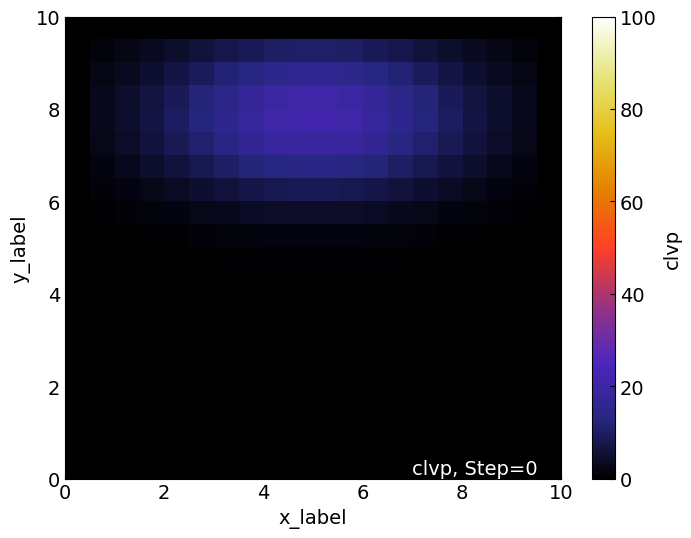

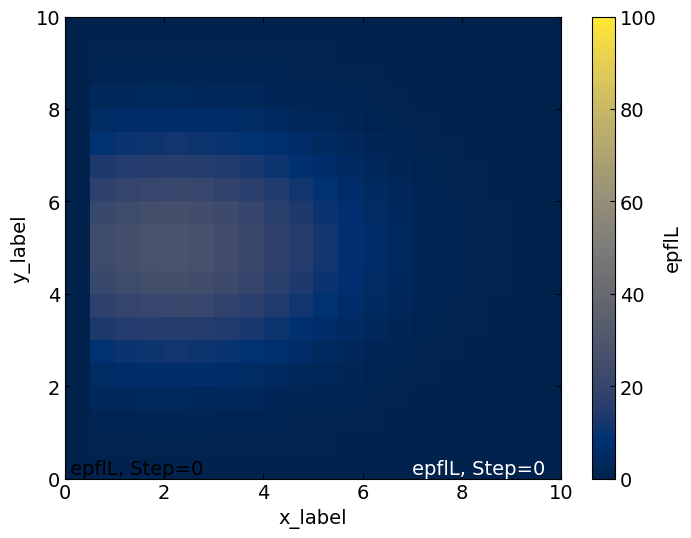

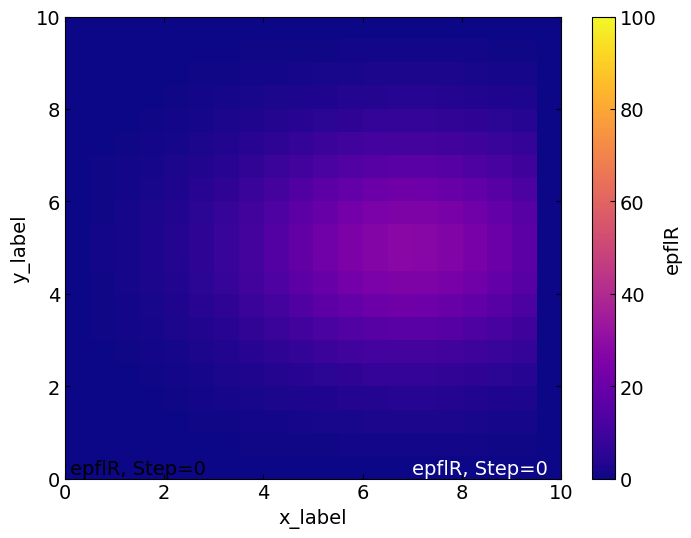

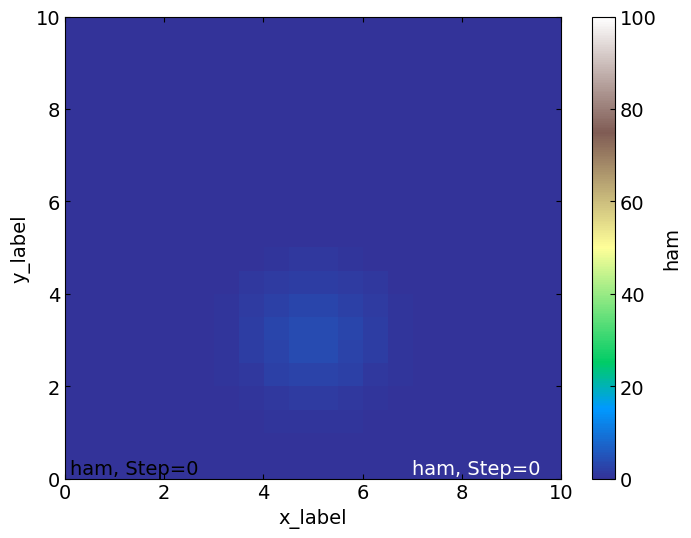

In [ ]:
# Initial field
x, y = np.linspace(0, x_max, int(x_max / dx)), np.linspace(0, y_max, int(y_max / dy))
wusr, wusp, clvr, clvp, erfL, erfR, ham = initial_field(x, y)
#plot(x, y, wus, 0, dir, 0)


# 境界条件を設定する
wusr = boundary_condition(wusr)
wusp = boundary_condition(wusp)
clvr = boundary_condition(clvr)
clvp = boundary_condition(clvp)
erfL = boundary_condition(erfL)
erfR = boundary_condition(erfR)
ham = boundary_condition(ham)


# Save condition  1=save, 0=not save
plot(x, y, wusr, 0, wusr_str, c_wusr, 0)
plot(x, y, wusp, 0, wusp_str, c_wusp, 0)
plot(x, y, clvr, 0, clvr_str, c_clvr, 0)
plot(x, y, clvp, 0, clvp_str, c_clvp, 0)
plot(x, y, erfL, 0, erfL_str, c_erfL, 0)
plot(x, y, erfR, 0, erfR_str, c_erfR, 0)
plot(x, y, ham, 0, ham_str, c_ham, 0)


nu_x, nu_y= 0.002 0.002
Iteration= 0


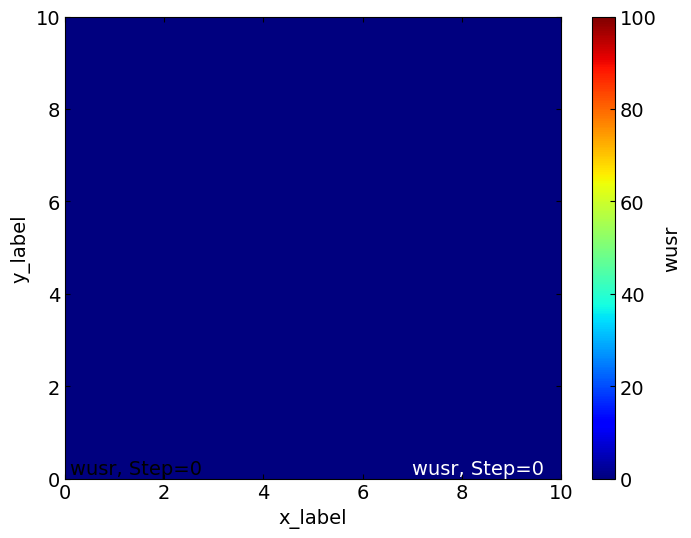

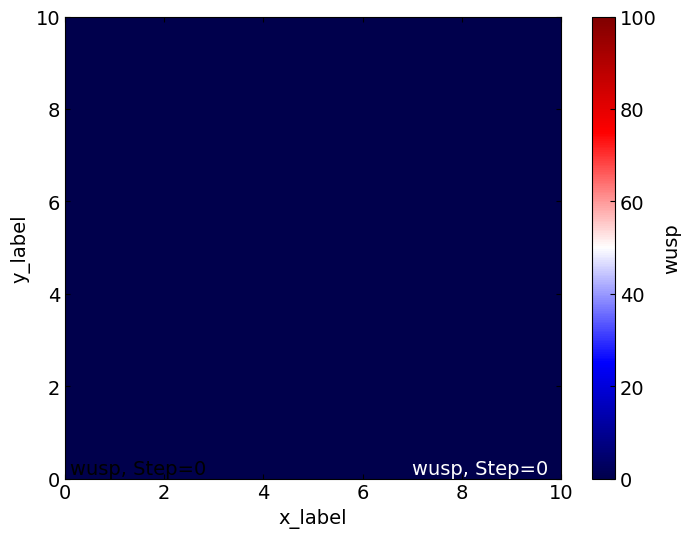

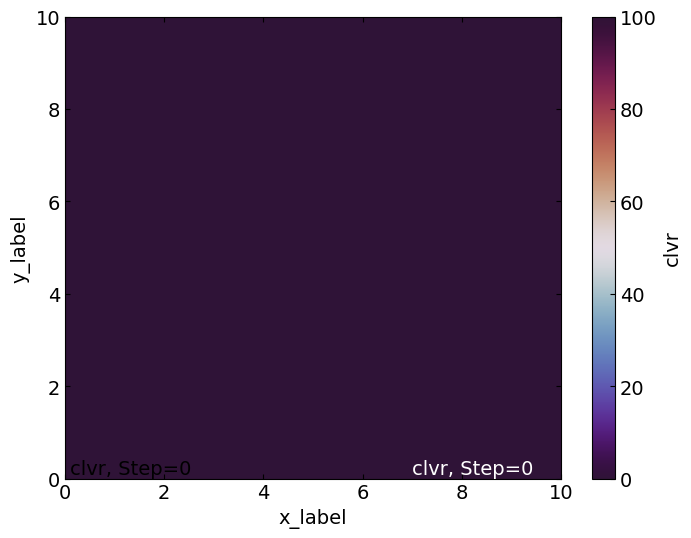

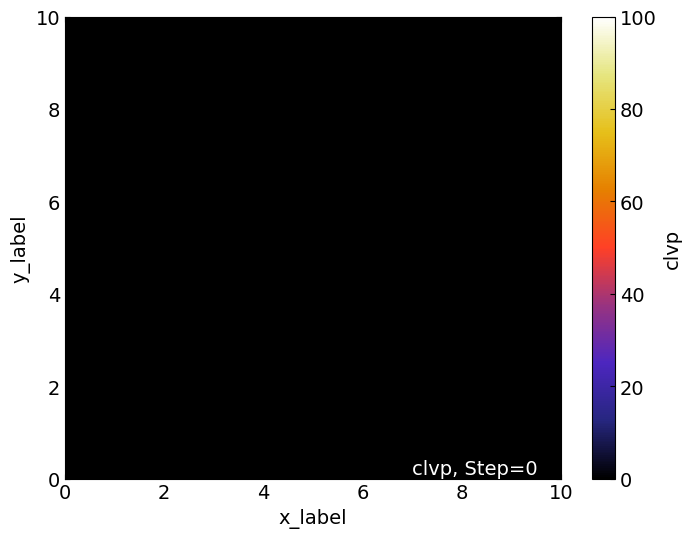

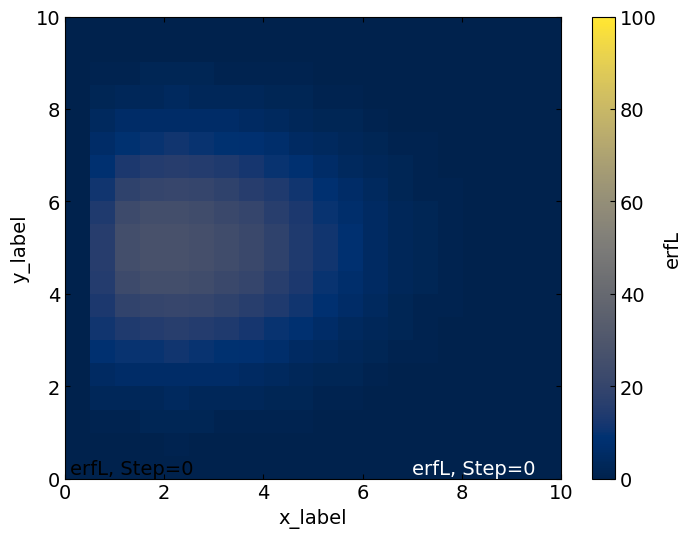

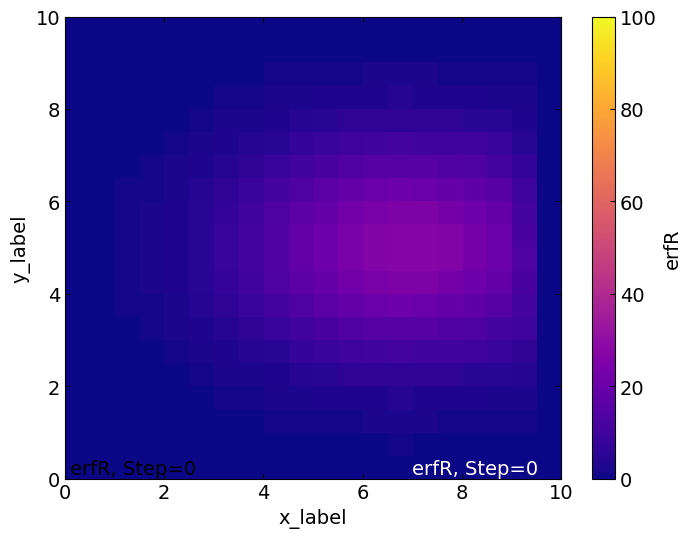

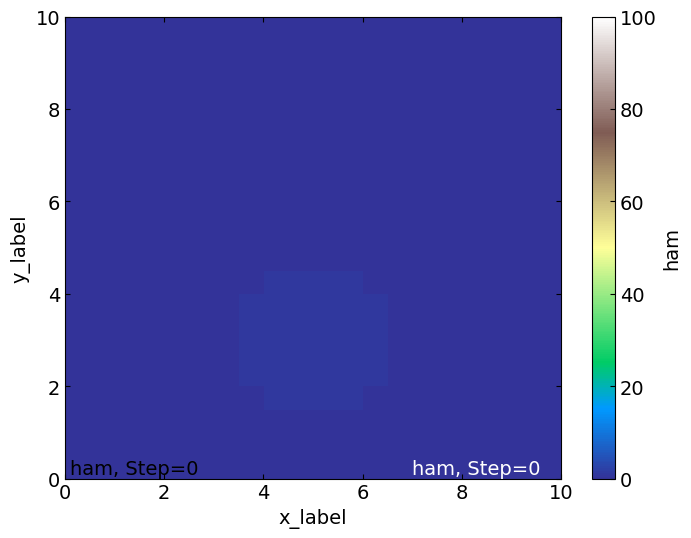

Iteration= 10


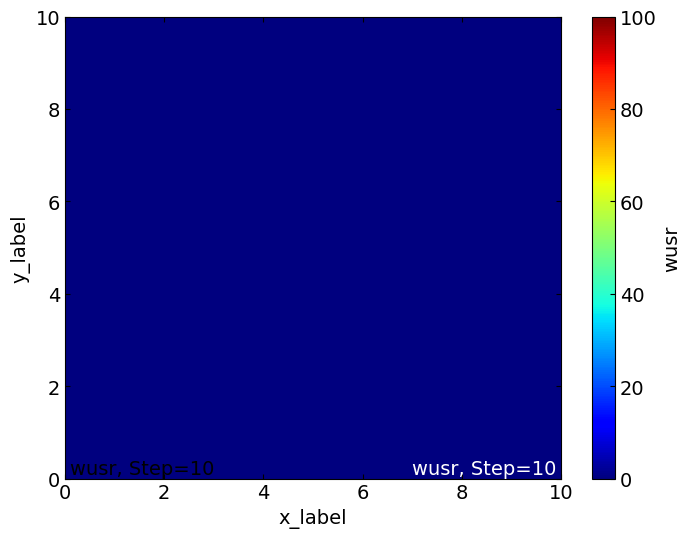

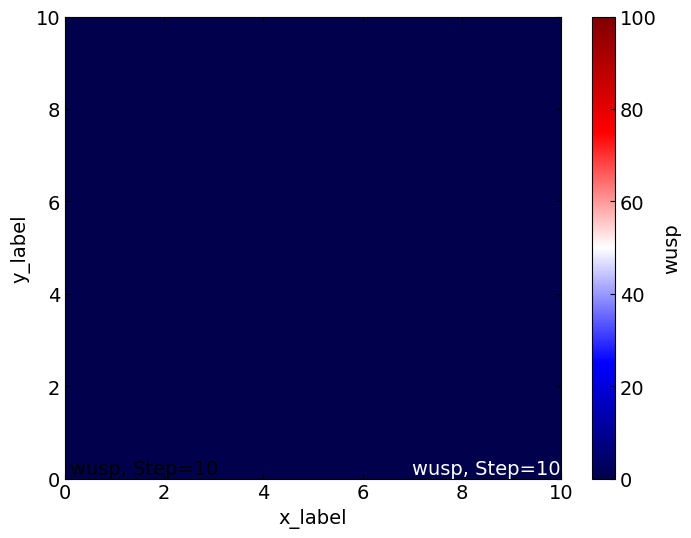

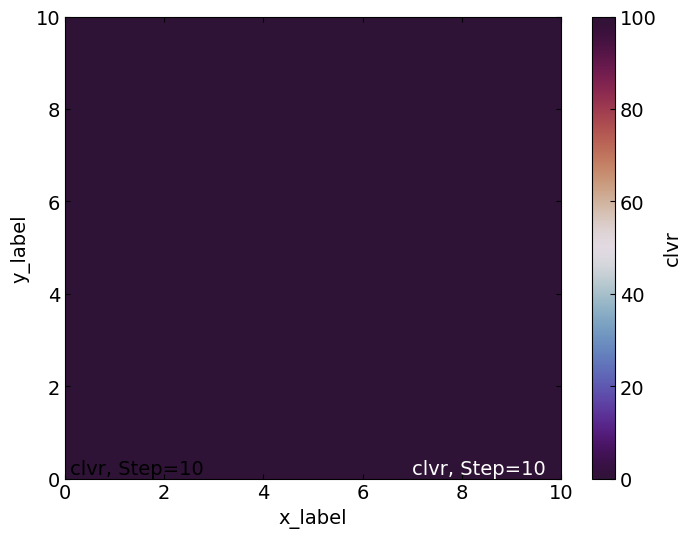

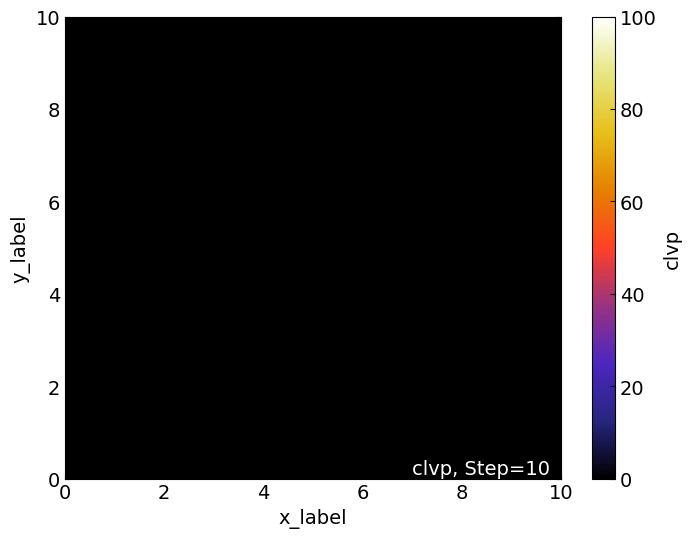

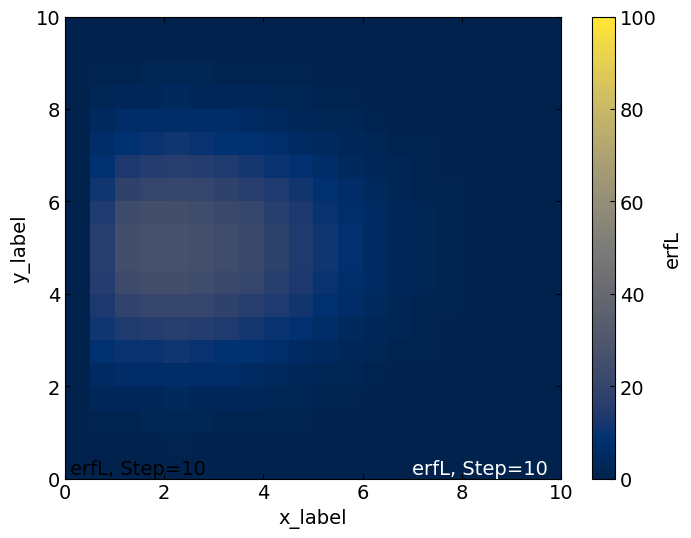

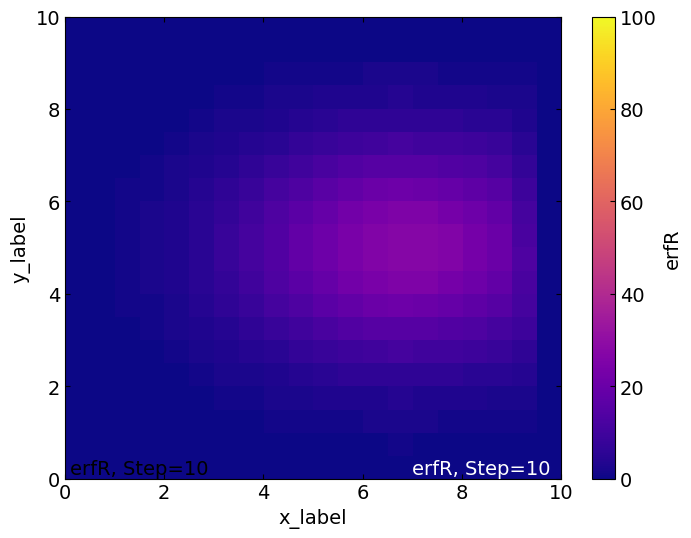

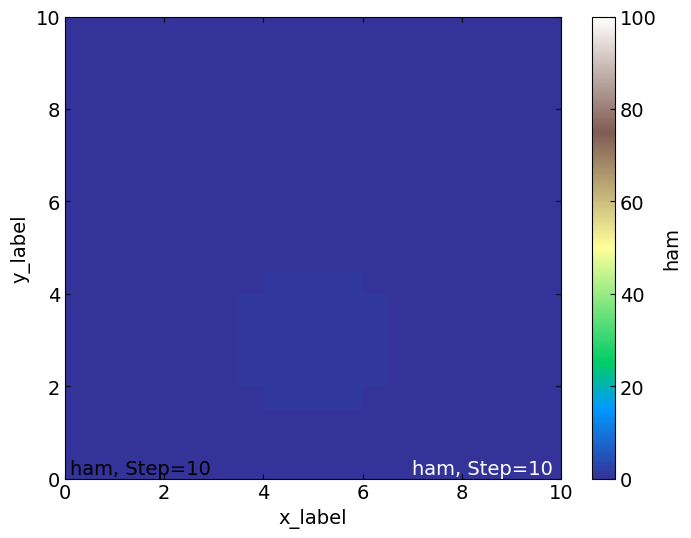

Iteration= 20


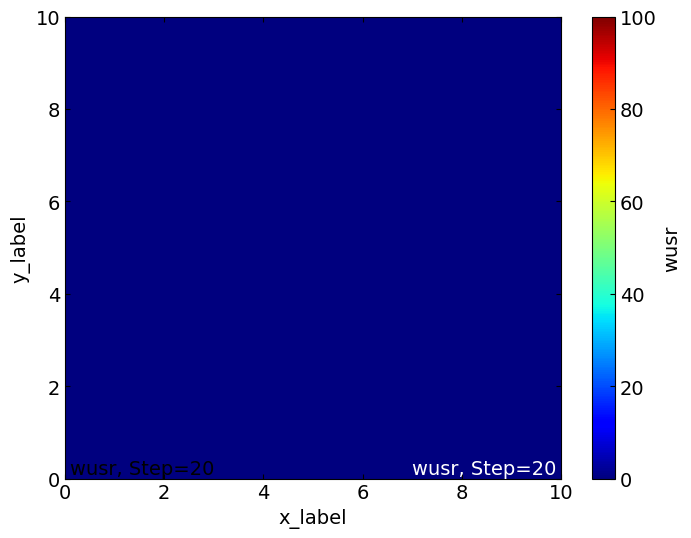

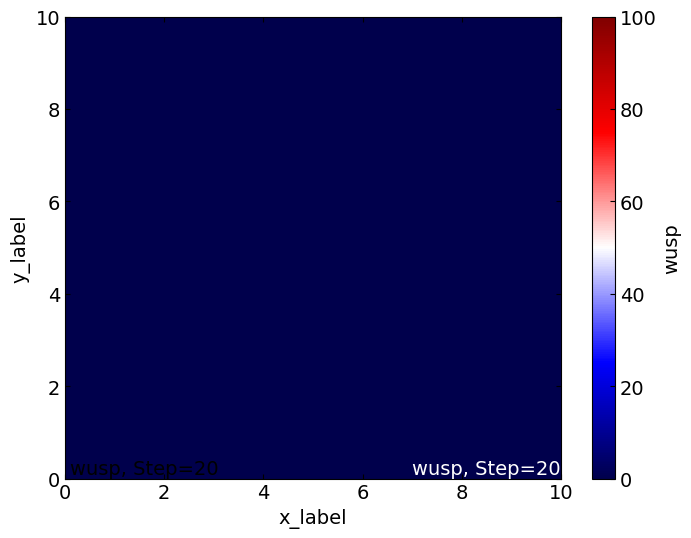

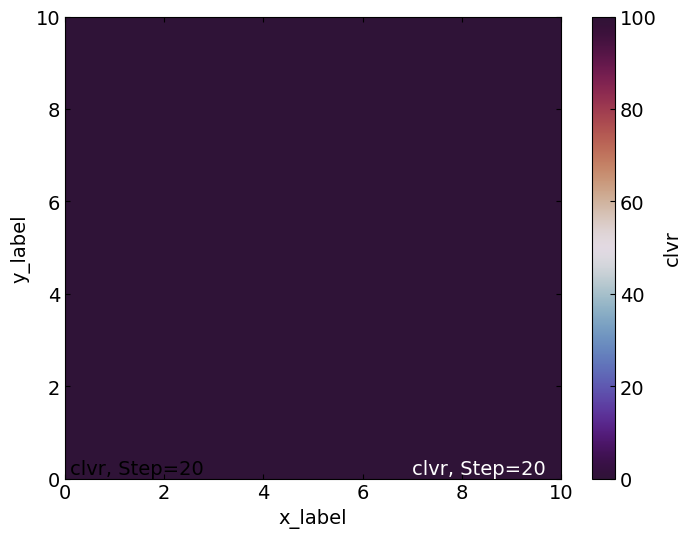

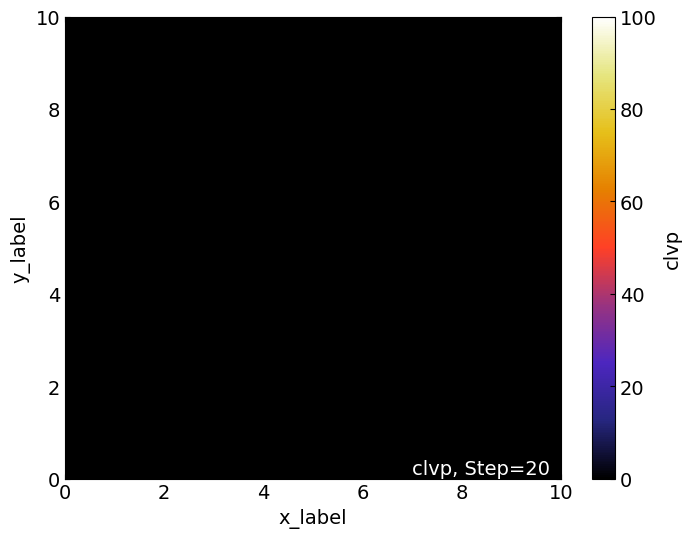

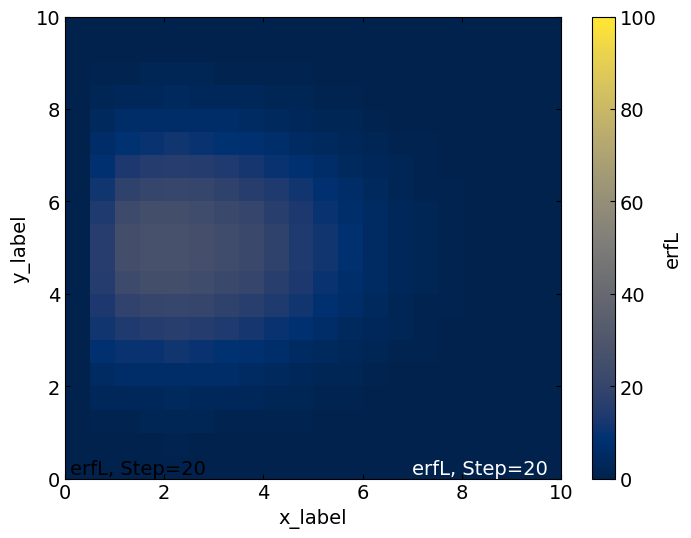

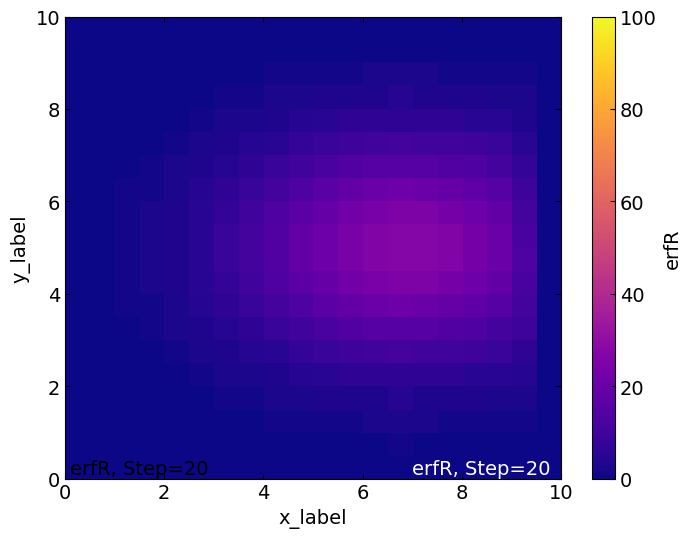

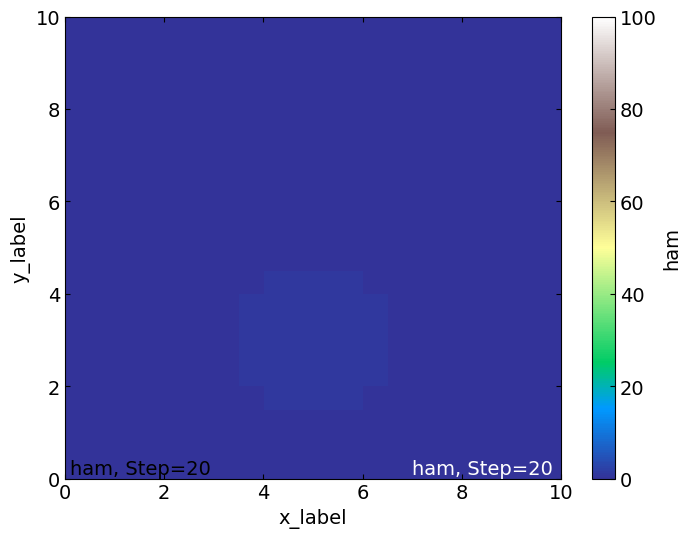

Iteration= 30


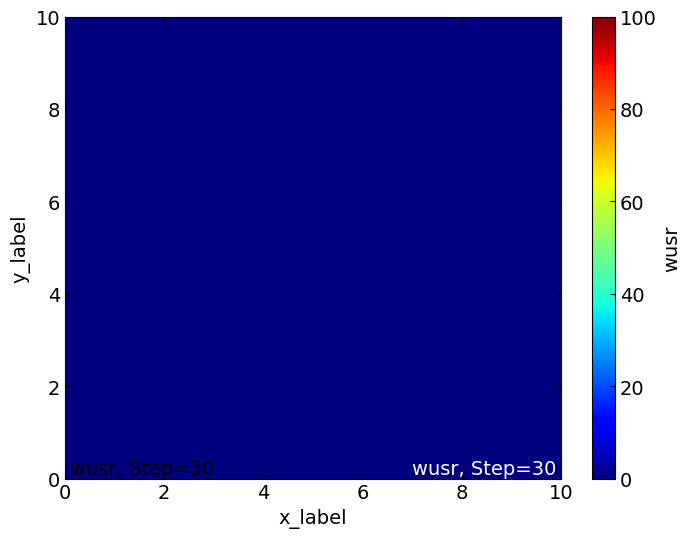

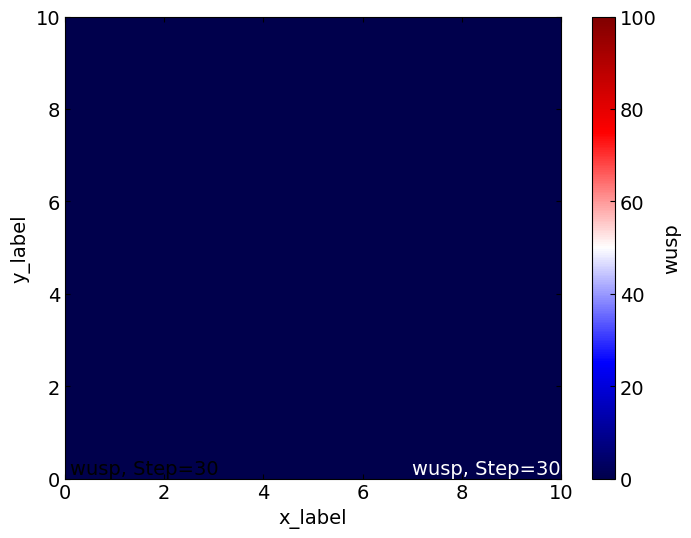

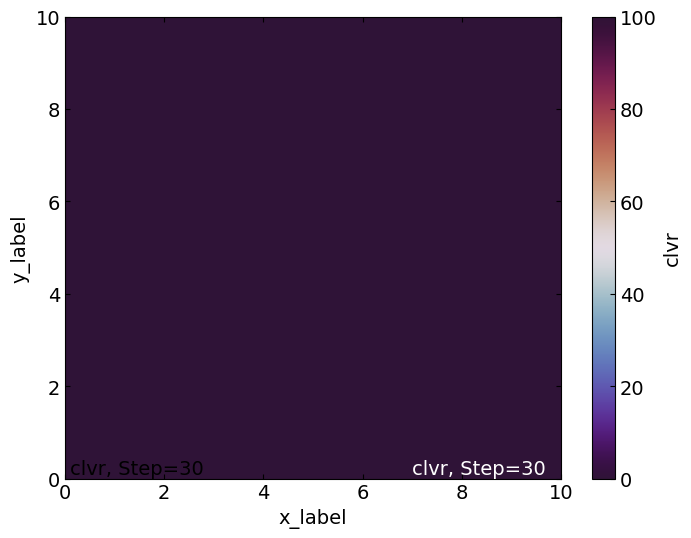

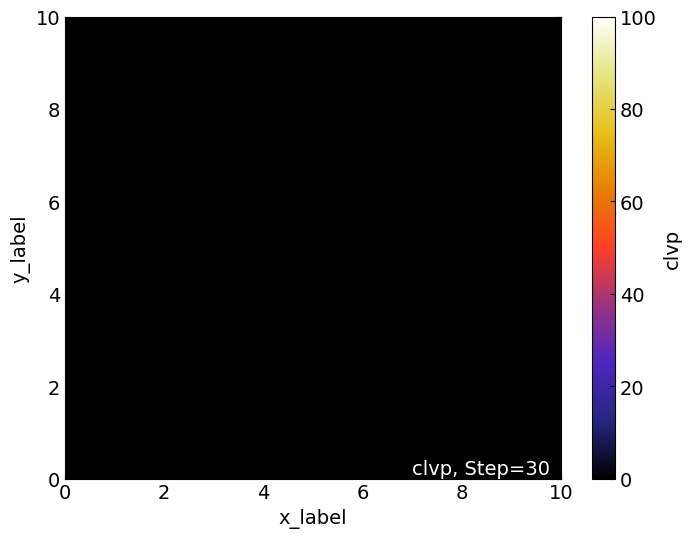

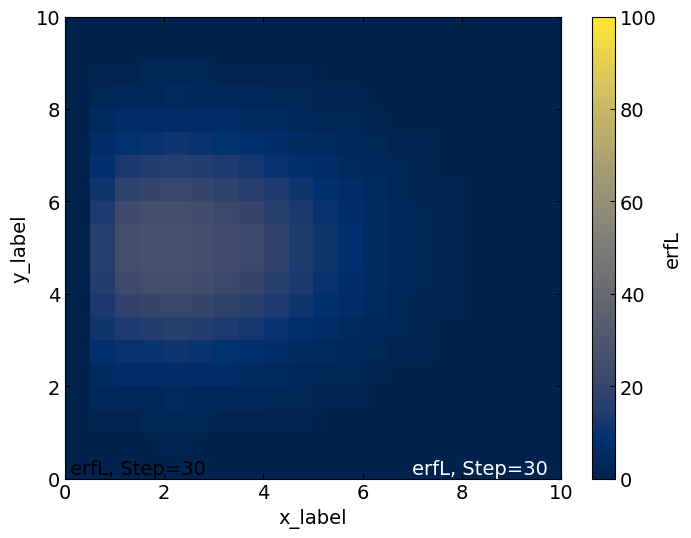

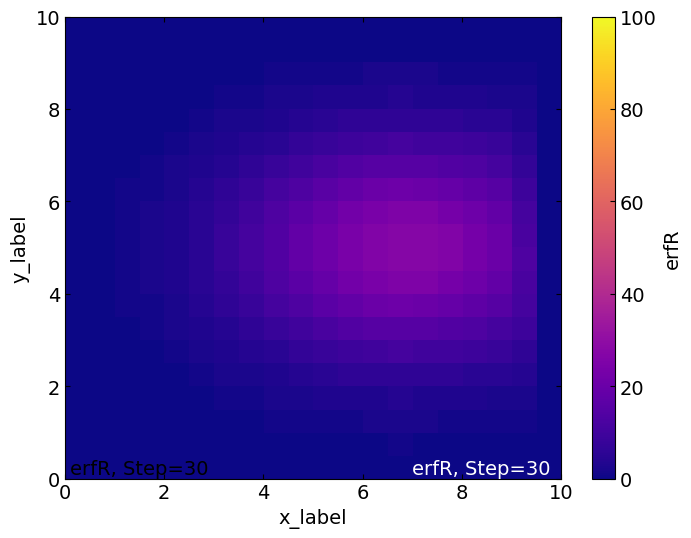

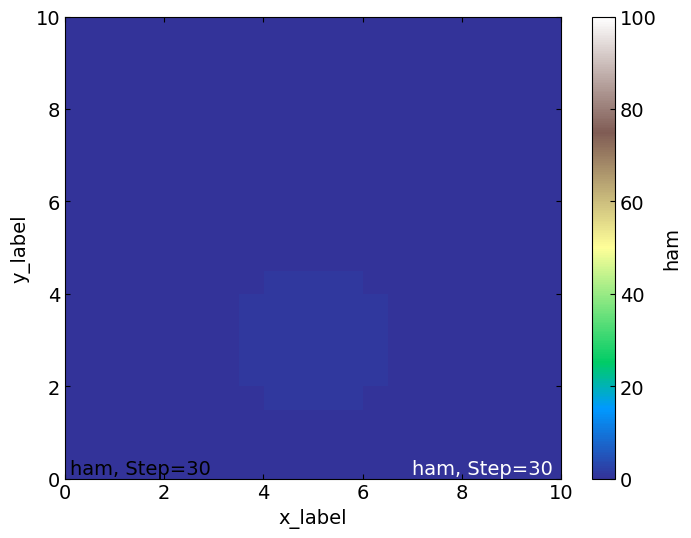

Iteration= 40


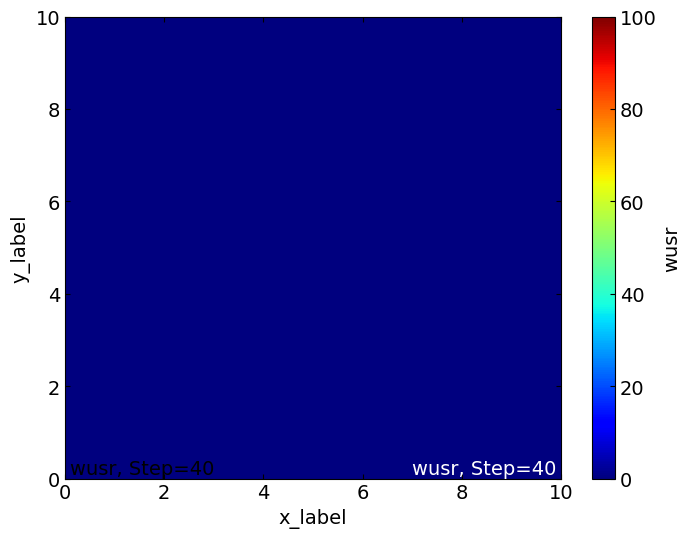

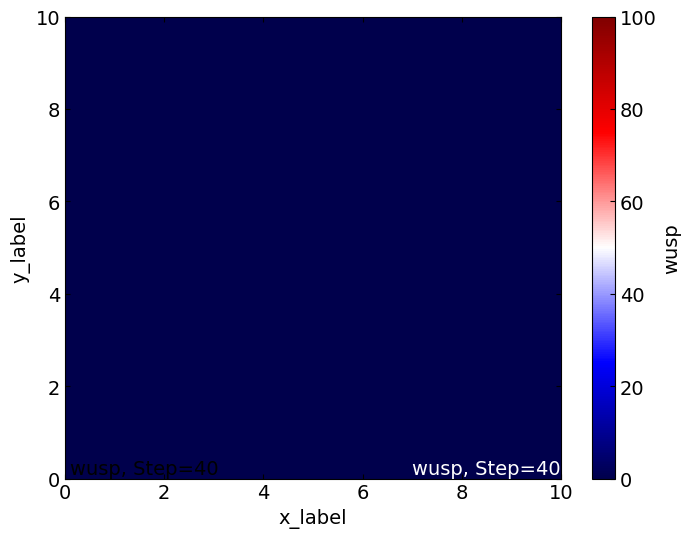

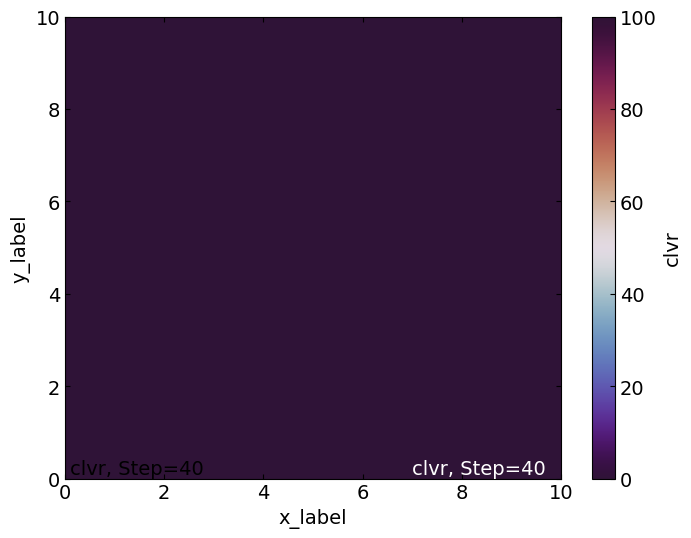

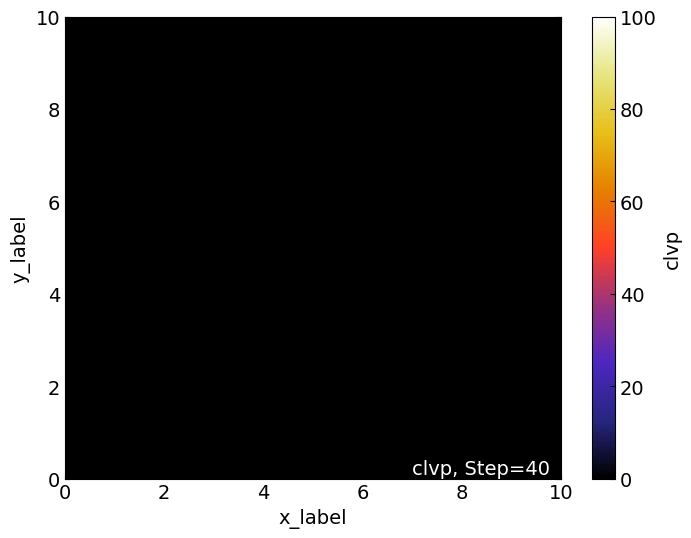

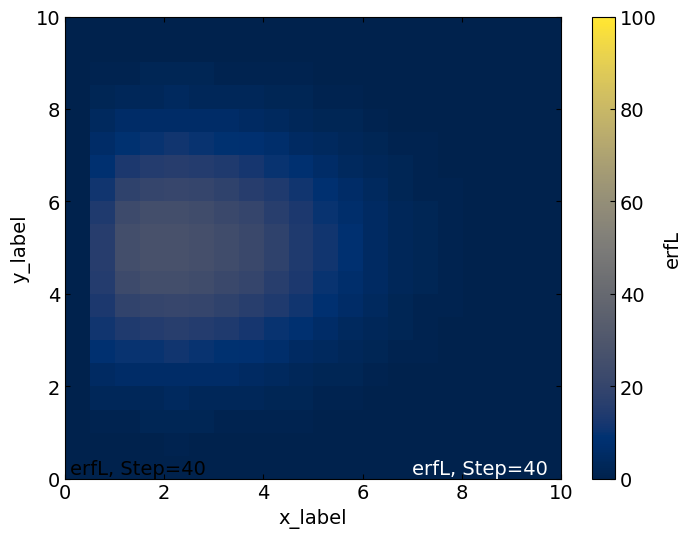

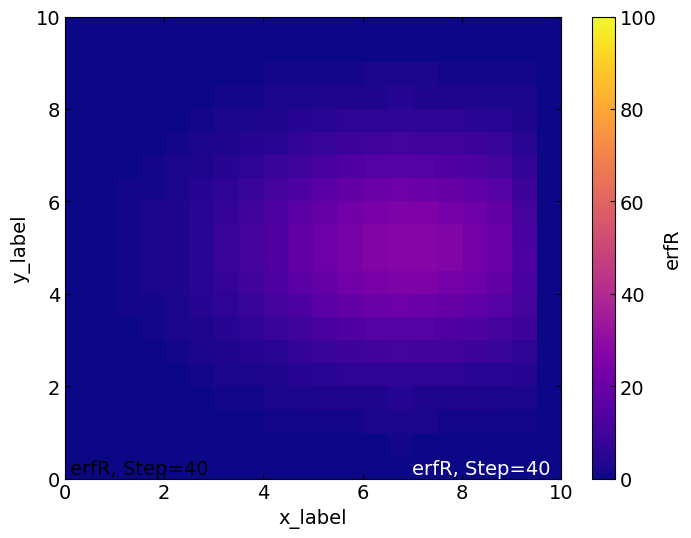

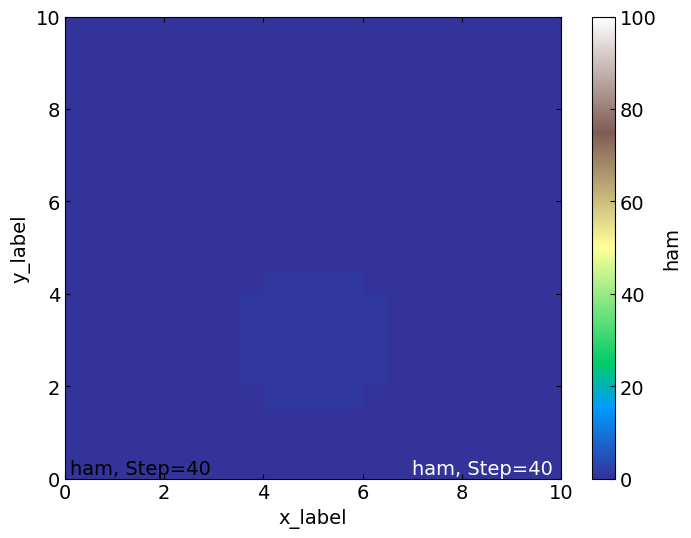

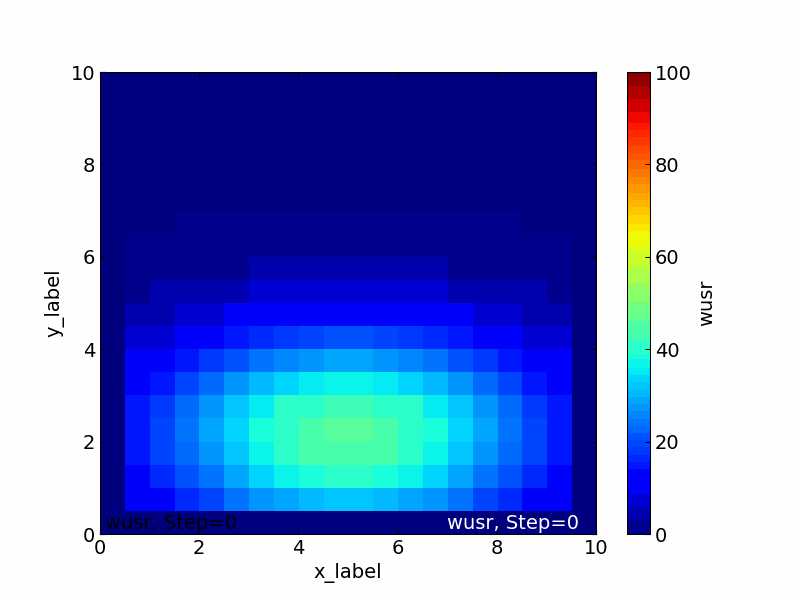

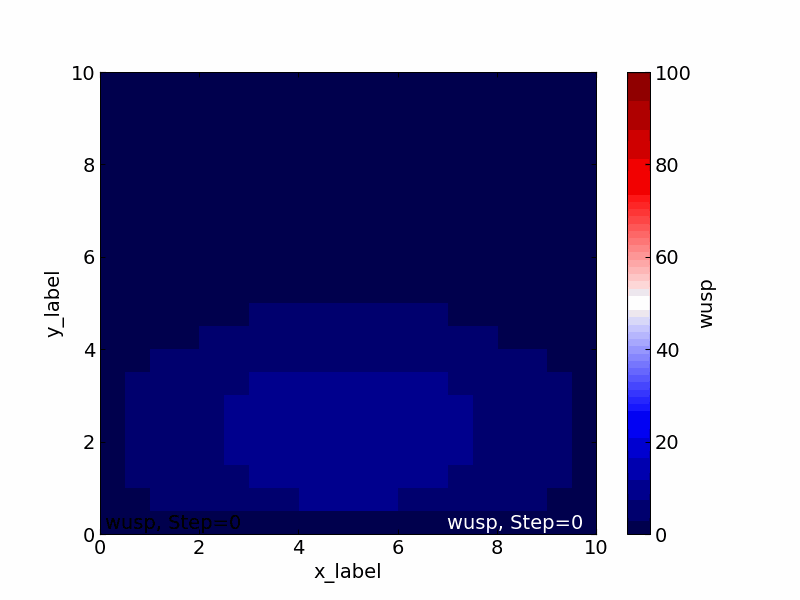

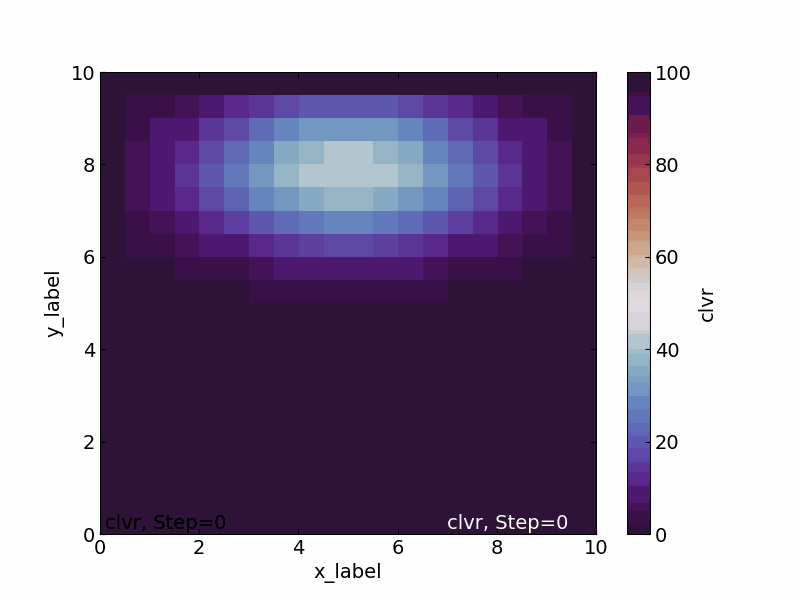

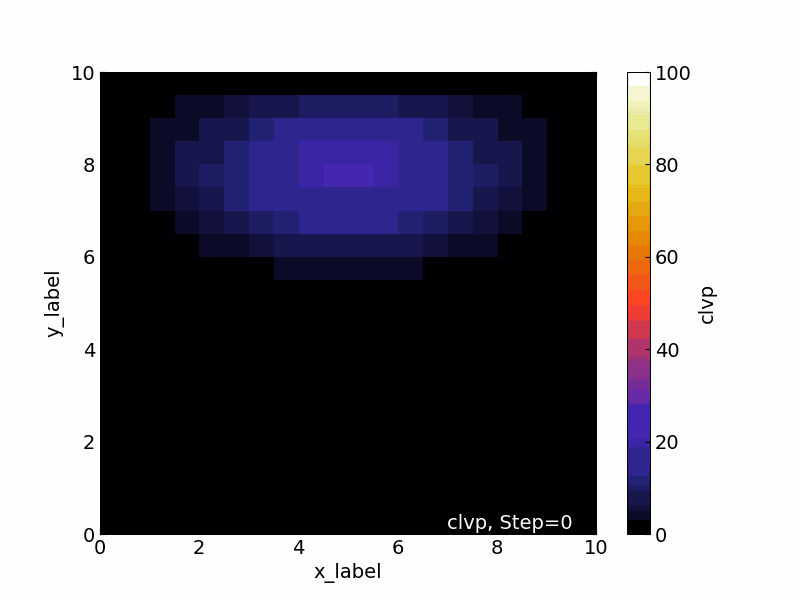

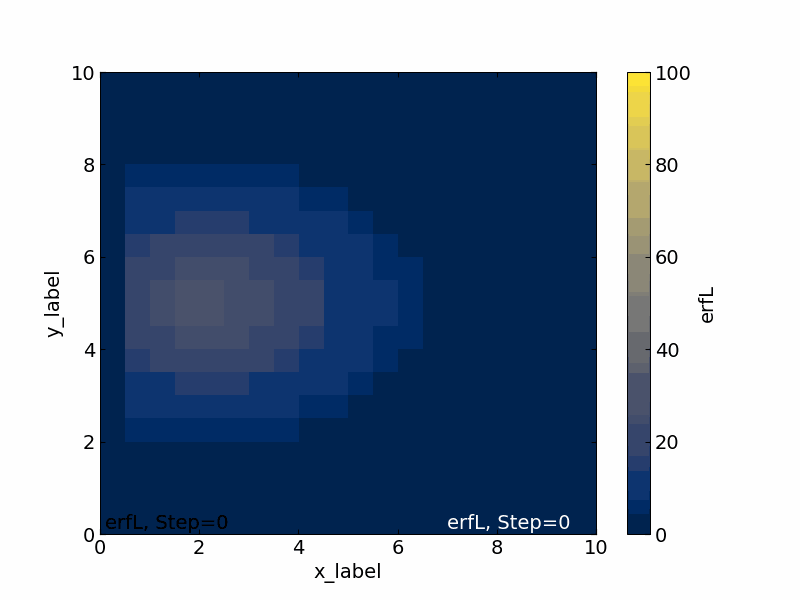

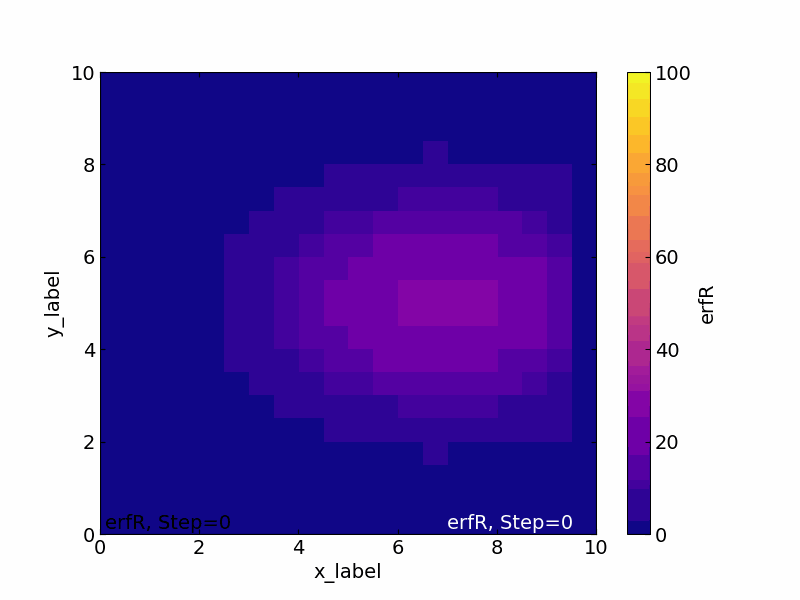

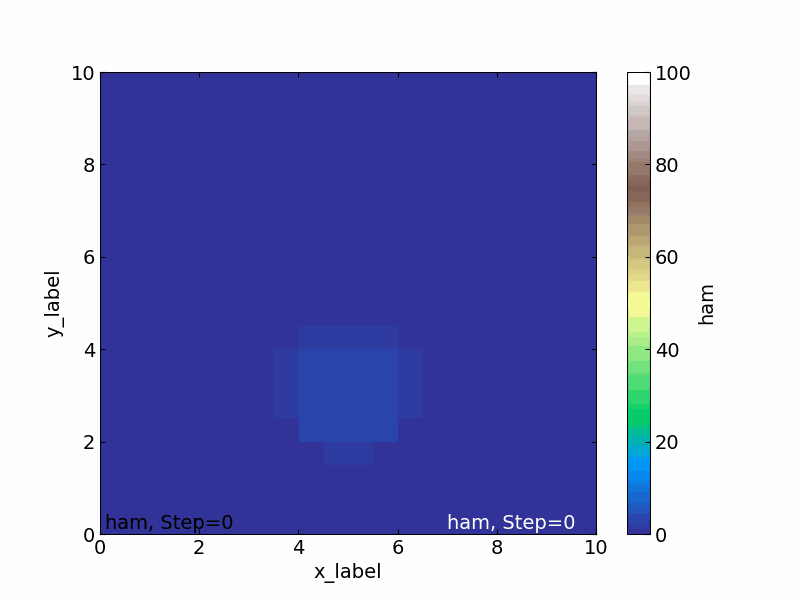

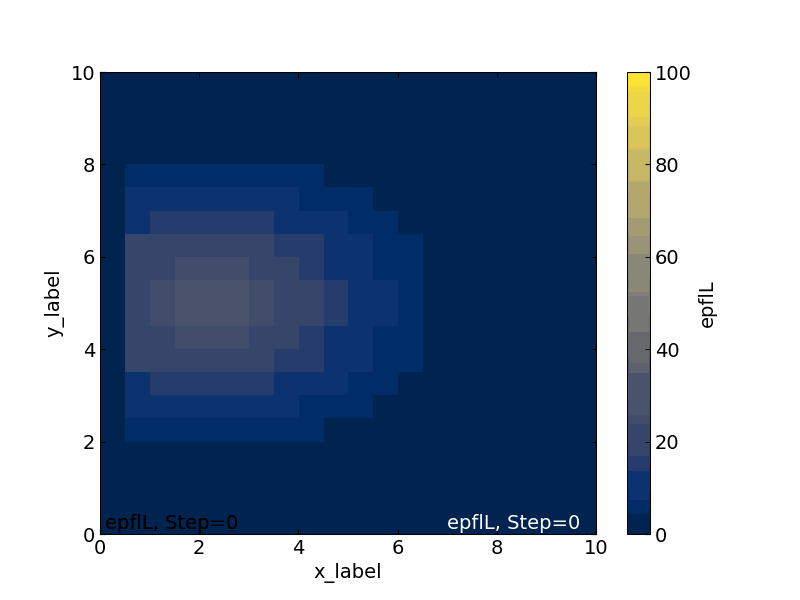

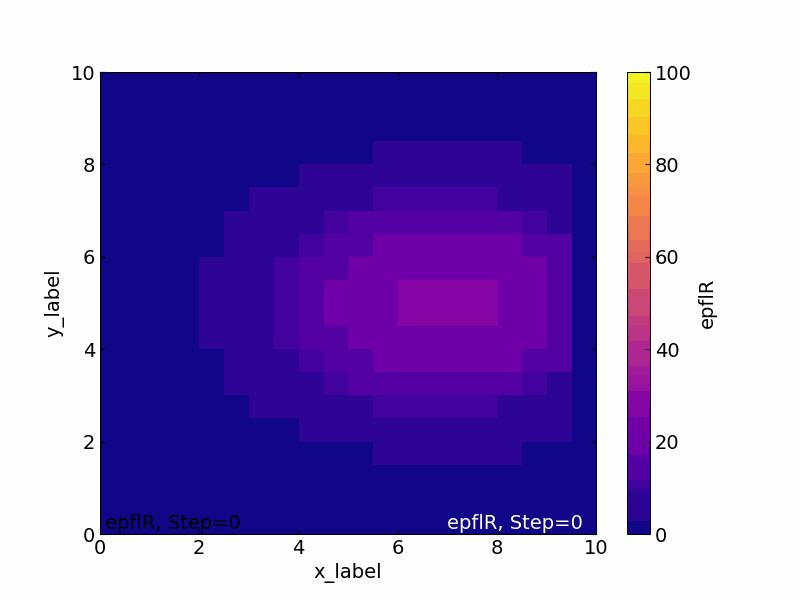

In [ ]:
# Initial
if __name__ == '__main__':
    # 安定性の確認
  nu_x, nu_y = a * dt / dx ** 2, a * dt / dy ** 2
  print('nu_x, nu_y=', nu_x, nu_y)


  # 計算を実行
  sol_2d_diffusion(x, y, wusr, wusp, clvr, clvp, erfL, erfR, ham, pull_sol, 0)



  # GIFを作成
  for z_key, images in img_stock.items():
      gif_bytes = io.BytesIO()
      images[0].save(gif_bytes, format='GIF', save_all=True, append_images=images[1:], duration=900, loop=0)

      # GIFを表示
      gif_bytes.seek(0)
      display.display(display.Image(data=gif_bytes.getvalue(), format='png'))

      gif_filename = f"{z_key}_animation.gif"

      """GIFを保存
      with open(gif_filename, 'wb') as f:
          f.write(gif_bytes.getvalue())

      files.download(gif_filename)
      """
